In [1]:
import warnings
warnings.filterwarnings("ignore")
from nlp_utils import *


In [6]:


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.manifold import TSNE

from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.stem import WordNetLemmatizer 

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from collections import Counter
from num2words import num2words

import nltk
import os
import string
import numpy as np
import copy
import pandas as pd
import pickle
import re
import math



In [48]:
import spacy
import en_ner_bionlp13cg_md
nlp = en_ner_bionlp13cg_md.load()

In [7]:
df = pd.read_csv("mtsamples.csv")

In [8]:
df.head()

,Unnamed: 0,description,medical_specialty,sample_name,transcription,keywords
0,0,A 23-year-old white female presents with comp...,Allergy / Immunology,Allergic Rhinitis,"SUBJECTIVE:, This 23-year-old white female pr...","allergy / immunology, allergic rhinitis, aller..."
1,1,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 2,"PAST MEDICAL HISTORY:, He has difficulty climb...","bariatrics, laparoscopic gastric bypass, weigh..."
2,2,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 1,"HISTORY OF PRESENT ILLNESS: , I have seen ABC ...","bariatrics, laparoscopic gastric bypass, heart..."
3,3,2-D M-Mode. Doppler.,Cardiovascular / Pulmonary,2-D Echocardiogram - 1,"2-D M-MODE: , ,1. Left atrial enlargement wit...","cardiovascular / pulmonary, 2-d m-mode, dopple..."
4,4,2-D Echocardiogram,Cardiovascular / Pulmonary,2-D Echocardiogram - 2,1. The left ventricular cavity size and wall ...,"cardiovascular / pulmonary, 2-d, doppler, echo..."


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4999 entries, 0 to 4998
Data columns (total 6 columns):
Unnamed: 0           4999 non-null int64
description          4999 non-null object
medical_specialty    4999 non-null object
sample_name          4999 non-null object
transcription        4966 non-null object
keywords             3931 non-null object
dtypes: int64(1), object(5)
memory usage: 234.5+ KB


In [11]:
cat = df.groupby(df['medical_specialty'])


In [13]:
cat['description'].count()
data_categories=cat

In [14]:
filtered_cat = data_categories.filter(lambda x:x.shape[0] > 50)
final_cat = filtered_cat.groupby(filtered_cat['medical_specialty'])
final_cat['description'].count()

medical_specialty
 Cardiovascular / Pulmonary        372
 Consult - History and Phy.        516
 Discharge Summary                 108
 ENT - Otolaryngology               98
 Emergency Room Reports             75
 Gastroenterology                  230
 General Medicine                  259
 Hematology - Oncology              90
 Nephrology                         81
 Neurology                         223
 Neurosurgery                       94
 Obstetrics / Gynecology           160
 Office Notes                       51
 Ophthalmology                      83
 Orthopedic                        355
 Pain Management                    62
 Pediatrics - Neonatal              70
 Psychiatry / Psychology            53
 Radiology                         273
 SOAP / Chart / Progress Notes     166
 Surgery                          1103
 Urology                           158
Name: description, dtype: int64

In [27]:
filtered_data_categories = df

filtered_data_categories['medical_specialty'] =filtered_data_categories['medical_specialty'].apply(lambda x:str.strip(x))
mask = filtered_data_categories['medical_specialty'] == 'Surgery'
filtered_data_categories = filtered_data_categories[~mask]
mask = filtered_data_categories['medical_specialty'] == 'SOAP / Chart / Progress Notes'
filtered_data_categories = filtered_data_categories[~mask]
mask = filtered_data_categories['medical_specialty'] == 'Office Notes'
filtered_data_categories = filtered_data_categories[~mask]
mask = filtered_data_categories['medical_specialty'] == 'Consult - History and Phy.'
filtered_data_categories = filtered_data_categories[~mask]
mask = filtered_data_categories['medical_specialty'] == 'Emergency Room Reports'
filtered_data_categories = filtered_data_categories[~mask]
mask = filtered_data_categories['medical_specialty'] == 'Discharge Summary'
filtered_data_categories = filtered_data_categories[~mask]

'''
mask = filtered_data_categories['medical_specialty'] == 'Pediatrics - Neonatal'
filtered_data_categories = filtered_data_categories[~mask]
'''
mask = filtered_data_categories['medical_specialty'] == 'Pain Management'
filtered_data_categories = filtered_data_categories[~mask]
mask = filtered_data_categories['medical_specialty'] == 'General Medicine'
filtered_data_categories = filtered_data_categories[~mask]


mask = filtered_data_categories['medical_specialty'] == 'Neurosurgery'
filtered_data_categories.loc[mask, 'medical_specialty'] = 'Neurology'
mask = filtered_data_categories['medical_specialty'] == 'Nephrology'
filtered_data_categories.loc[mask, 'medical_specialty'] = 'Urology'
final_data_categories = filtered_data_categories.groupby(filtered_data_categories['medical_specialty'])


i=1
print('============Reduced Categories======================')
for catName,dataCategory in final_data_categories:
    print('Cat:'+str(i)+' '+catName + ' : '+ str(len(dataCategory)) )
    i = i+1

print('============Reduced Categories======================')


data = filtered_data_categories[['transcription', 'medical_specialty']]
data = data.drop(data[data['transcription'].isna()].index)
data.shape

============Reduced Categories======================
Cat:1 Allergy / Immunology : 7
Cat:2 Autopsy : 8
Cat:3 Bariatrics : 18
Cat:4 Cardiovascular / Pulmonary : 372
Cat:5 Chiropractic : 14
Cat:6 Cosmetic / Plastic Surgery : 27
Cat:7 Dentistry : 27
Cat:8 Dermatology : 29
Cat:9 Diets and Nutritions : 10
Cat:10 ENT - Otolaryngology : 98
Cat:11 Endocrinology : 19
Cat:12 Gastroenterology : 230
Cat:13 Hematology - Oncology : 90
Cat:14 Hospice - Palliative Care : 6
Cat:15 IME-QME-Work Comp etc. : 16
Cat:16 Lab Medicine - Pathology : 8
Cat:17 Letters : 23
Cat:18 Neurology : 317
Cat:19 Obstetrics / Gynecology : 160
Cat:20 Ophthalmology : 83
Cat:21 Orthopedic : 355
Cat:22 Pediatrics - Neonatal : 70
Cat:23 Physical Medicine - Rehab : 21
Cat:24 Podiatry : 47
Cat:25 Psychiatry / Psychology : 53
Cat:26 Radiology : 273
Cat:27 Rheumatology : 10
Cat:28 Sleep Medicine : 20
Cat:29 Speech - Language : 9
Cat:30 Urology : 239
============Reduced Categories======================


(2643, 2)

In [31]:
data1 = df.groupby(data['medical_specialty'])
filter_cat = data1.filter(lambda x:x.shape[0] > 50)
final_cat = filtered_cat.groupby(filter_cat['medical_specialty'])
final_cat['description'].count()

medical_specialty
Cardiovascular / Pulmonary    371
ENT - Otolaryngology           96
Gastroenterology              224
Hematology - Oncology          90
Nephrology                     81
Neurology                     223
Neurosurgery                   94
Obstetrics / Gynecology       155
Ophthalmology                  83
Orthopedic                    355
Pediatrics - Neonatal          70
Psychiatry / Psychology        53
Radiology                     273
Urology                       156
Name: description, dtype: int64

In [40]:
data = filter_cat[['transcription', 'medical_specialty']]
data = data.drop(data[data['transcription'].isna()].index)
data.shape

(2324, 2)

In [46]:
data['medical_specialty'].value_counts()

Cardiovascular / Pulmonary    371
Orthopedic                    355
Radiology                     273
Gastroenterology              224
Neurology                     223
Urology                       156
Obstetrics / Gynecology       155
ENT - Otolaryngology           96
Neurosurgery                   94
Hematology - Oncology          90
Ophthalmology                  83
Nephrology                     81
Pediatrics - Neonatal          70
Psychiatry / Psychology        53
Name: medical_specialty, dtype: int64

<AxesSubplot:xlabel='count', ylabel='medical_specialty'>

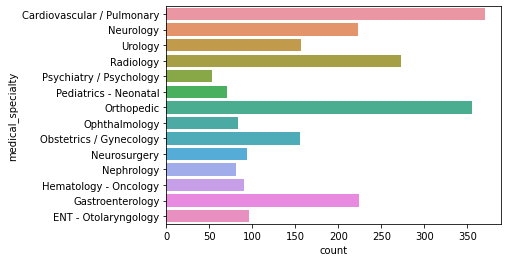

In [47]:
sns.countplot(y=data['medical_specialty'],data=data)

In [49]:
data

,transcription,medical_specialty
3,"2-D M-MODE: , ,1. Left atrial enlargement wit...",Cardiovascular / Pulmonary
4,1. The left ventricular cavity size and wall ...,Cardiovascular / Pulmonary
7,"2-D ECHOCARDIOGRAM,Multiple views of the heart...",Cardiovascular / Pulmonary
9,"DESCRIPTION:,1. Normal cardiac chambers size....",Cardiovascular / Pulmonary
11,"2-D STUDY,1. Mild aortic stenosis, widely calc...",Cardiovascular / Pulmonary
...,...,...
4972,"INDICATION: , Chest pain.,TYPE OF TEST: , Aden...",Cardiovascular / Pulmonary
4973,"CHIEF COMPLAINT: , Chest pain.,HISTORY OF PRES...",Cardiovascular / Pulmonary
4974,"HISTORY OF PRESENT ILLNESS: , The patient is a...",Cardiovascular / Pulmonary
4975,"HISTORY OF PRESENT ILLNESS: , Mr. ABC is a 60-...",Cardiovascular / Pulmonary


In [50]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2324 entries, 3 to 4976
Data columns (total 2 columns):
transcription        2324 non-null object
medical_specialty    2324 non-null object
dtypes: object(2)
memory usage: 134.5+ KB


In [51]:
data['y']=data['medical_specialty']
data.drop(['medical_specialty'], axis =1, inplace=True)

In [52]:
data

,transcription,y
3,"2-D M-MODE: , ,1. Left atrial enlargement wit...",Cardiovascular / Pulmonary
4,1. The left ventricular cavity size and wall ...,Cardiovascular / Pulmonary
7,"2-D ECHOCARDIOGRAM,Multiple views of the heart...",Cardiovascular / Pulmonary
9,"DESCRIPTION:,1. Normal cardiac chambers size....",Cardiovascular / Pulmonary
11,"2-D STUDY,1. Mild aortic stenosis, widely calc...",Cardiovascular / Pulmonary
...,...,...
4972,"INDICATION: , Chest pain.,TYPE OF TEST: , Aden...",Cardiovascular / Pulmonary
4973,"CHIEF COMPLAINT: , Chest pain.,HISTORY OF PRES...",Cardiovascular / Pulmonary
4974,"HISTORY OF PRESENT ILLNESS: , The patient is a...",Cardiovascular / Pulmonary
4975,"HISTORY OF PRESENT ILLNESS: , Mr. ABC is a 60-...",Cardiovascular / Pulmonary


In [58]:
def clean_text(text ): 
    text = text.translate(str.maketrans('', '', string.punctuation))
    text1 = ''.join([w for w in text if not w.isdigit()]) 
    REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
    #BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
    
    text2 = text1.lower()
    text2 = REPLACE_BY_SPACE_RE.sub('', text2) # replace REPLACE_BY_SPACE_RE symbols by space in text
    #text2 = BAD_SYMBOLS_RE.sub('', text2)
    return text2

def lemmatize_text(text):
    wordlist=[]
    lemmatizer = WordNetLemmatizer() 
    sentences=sent_tokenize(text)
    
    intial_sentences= sentences[0:1]
    final_sentences = sentences[len(sentences)-2: len(sentences)-1]
    
    for sentence in intial_sentences:
        words=word_tokenize(sentence)
        for word in words:
            wordlist.append(lemmatizer.lemmatize(word))
    for sentence in final_sentences:
        words=word_tokenize(sentence)
        for word in words:
            wordlist.append(lemmatizer.lemmatize(word))       
    return ' '.join(wordlist) 

In [59]:
import spacy
import en_ner_bionlp13cg_md
nlp = en_ner_bionlp13cg_md.load()

def process_Text( text):
    wordlist=[]
    doc = nlp(text)
    for ent in doc.ents:
        wordlist.append(ent.text)
    return ' '.join(wordlist) 

In [60]:
data['transcription'] = data['transcription'].apply(process_Text)
data['transcription'] = data['transcription'].apply(lemmatize_text)
data['transcription'] = data['transcription'].apply(clean_text)

# Cardiovascular / Pulmonary:


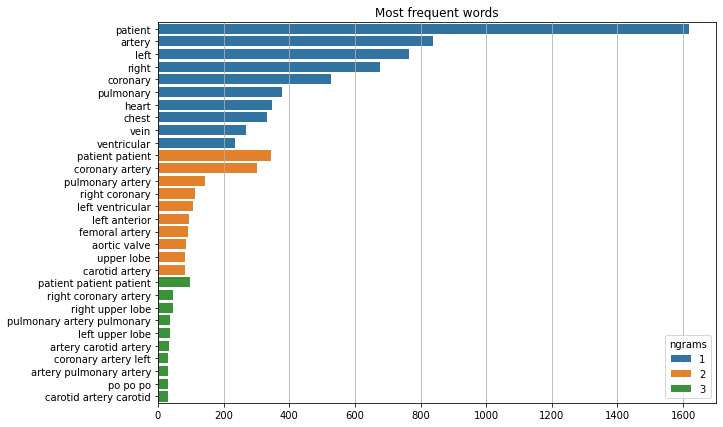

# Neurology:


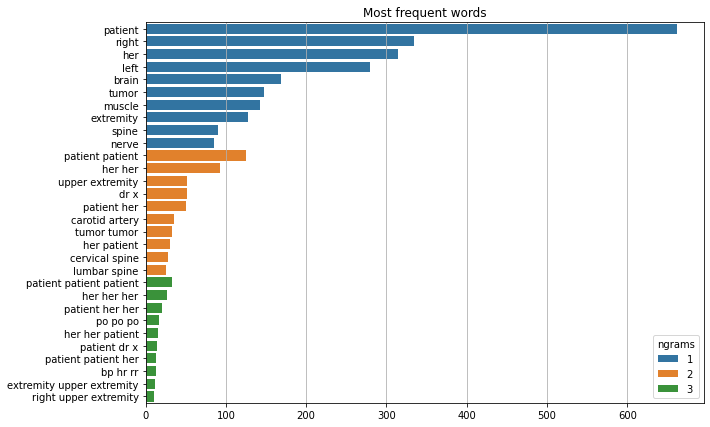

# Urology:


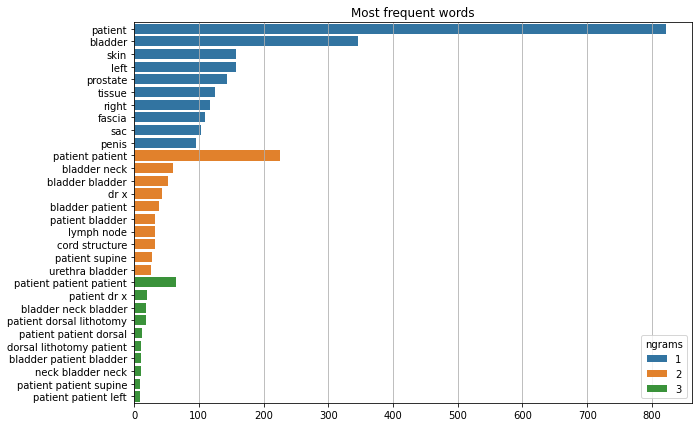

# Radiology:


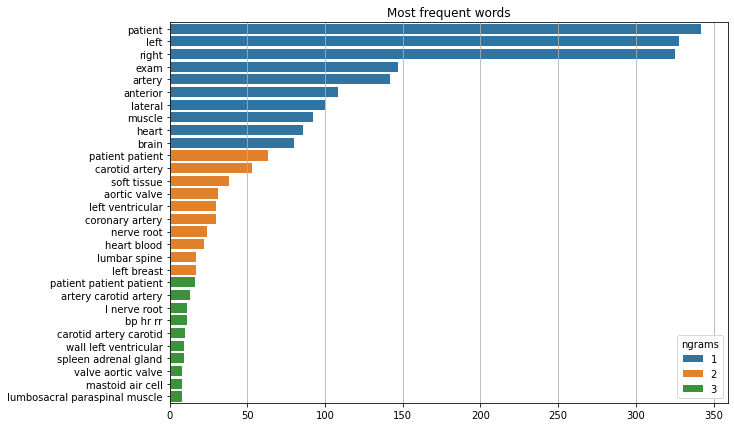

# Psychiatry / Psychology:


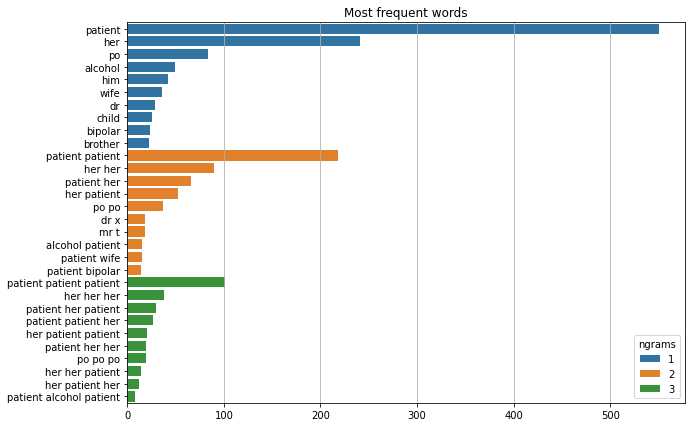

# Pediatrics - Neonatal:


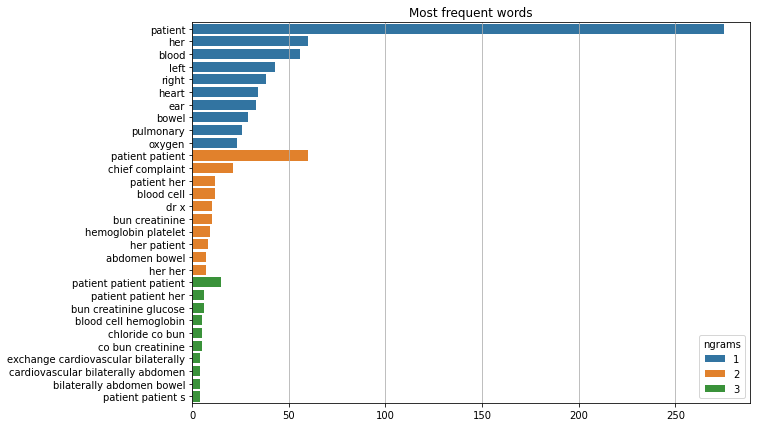

# Orthopedic:


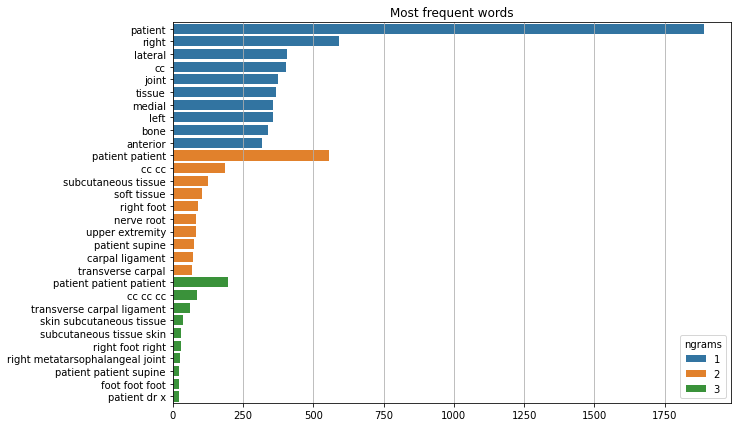

# Ophthalmology:


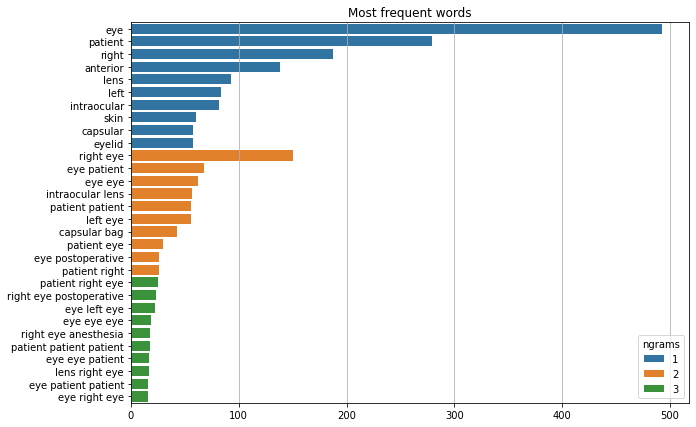

# Obstetrics / Gynecology:


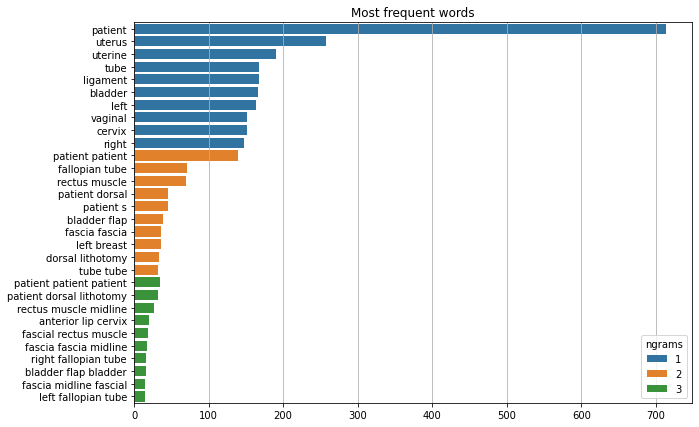

# Neurosurgery:


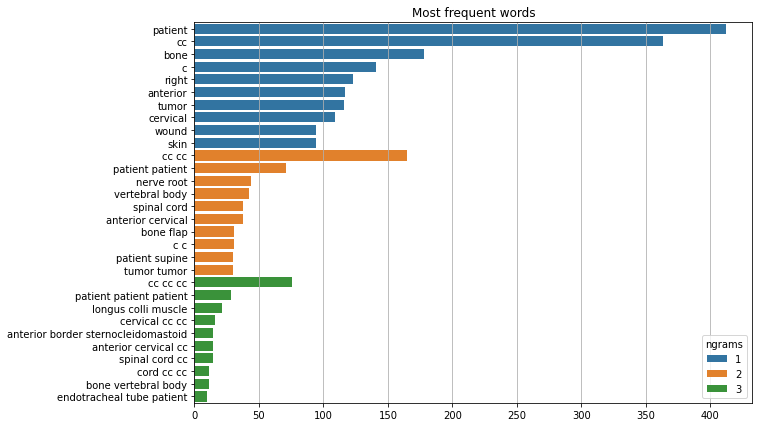

# Nephrology:


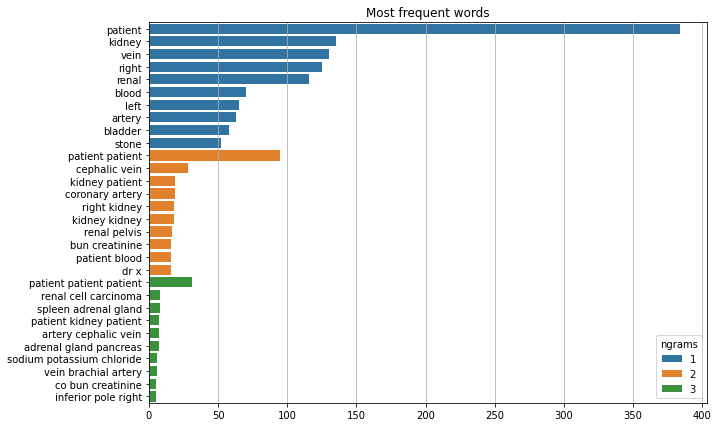

# Hematology - Oncology:


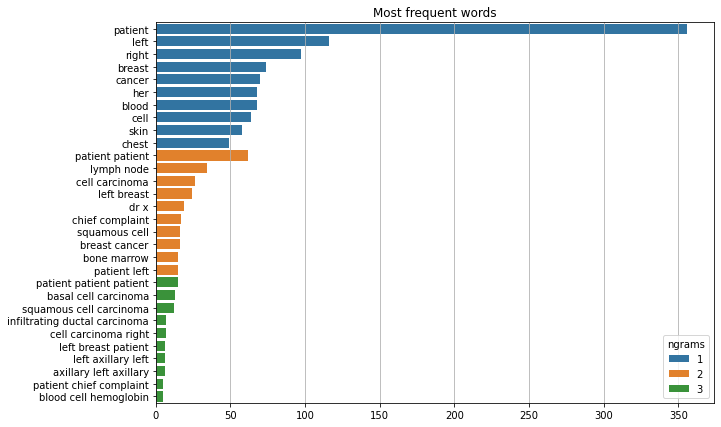

# Gastroenterology:


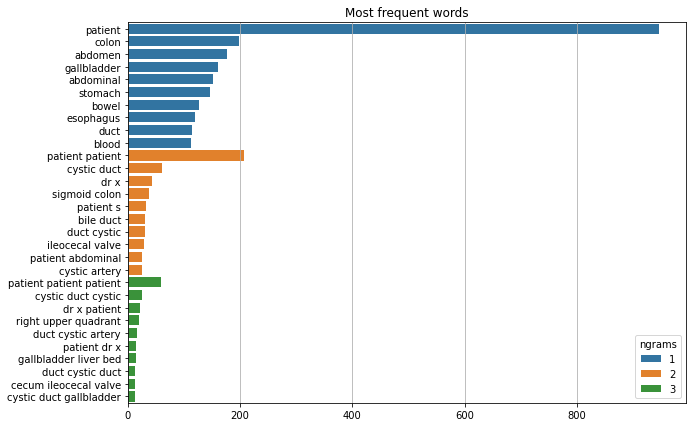

# ENT - Otolaryngology:


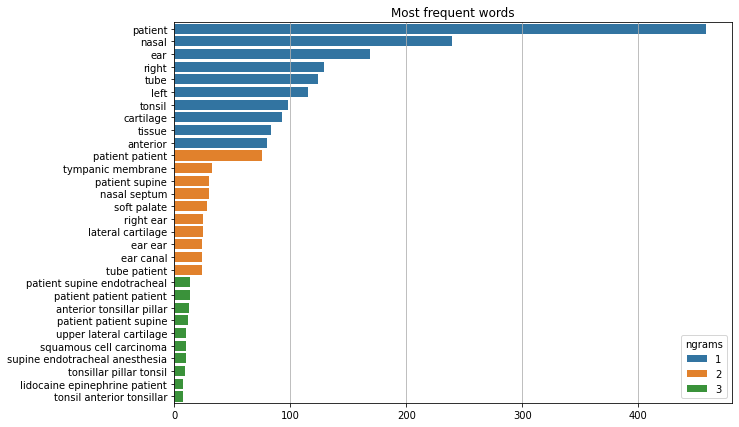

In [64]:
dtf_freq = pd.DataFrame()
for y in data["y"].unique():
    print("# {}:".format(y))
    dtf_y = word_freq(corpus=data[data["y"]==y]["transcription"], ngrams=[1,2,3], top=10, figsize=(10,7))
    dtf_y["y"] = y
    dtf_freq = dtf_freq.append(dtf_y)

In [ ]:
def remove_stop_words(data):
    stop_words = ['patient']
    words = word_tokenize(str(data))
    new_text = ""
    for w in words:
        if w not in stop_words and len(w) > 1:
            new_text = new_text + " " + w
    return new_text

In [65]:
# preprocess text
data2 = add_preprocessed_text(data, "transcription", lst_regex=None, lst_stopwords=['patient'], flg_stemm=False, flg_lemm=False)
data2.head()

--- found NAs ---
     transcription transcription_clean
166        patient                    
1525                                  
2017                                  
2047                                  
2195                                  


,transcription,y,transcription_clean
3,left atrial left ventricle left ventricular pe...,Cardiovascular / Pulmonary,left atrial left ventricle left ventricular pe...
4,left ventricular wall wall left ventricular ve...,Cardiovascular / Pulmonary,left ventricular wall wall left ventricular ve...
7,heart vessel vessel pericardial venous right a...,Cardiovascular / Pulmonary,heart vessel vessel pericardial venous right a...
9,motion pericardial,Cardiovascular / Pulmonary,motion pericardial
11,study mitral left ventricular aortic stenosis ...,Cardiovascular / Pulmonary,study mitral left ventricular aortic stenosis ...


# Cardiovascular / Pulmonary:


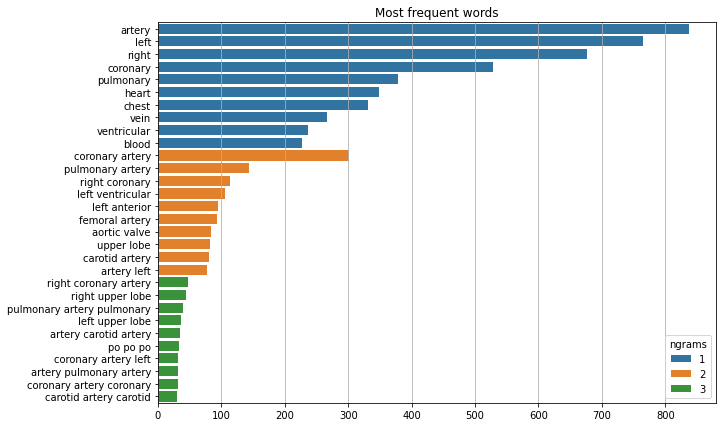

# Neurology:


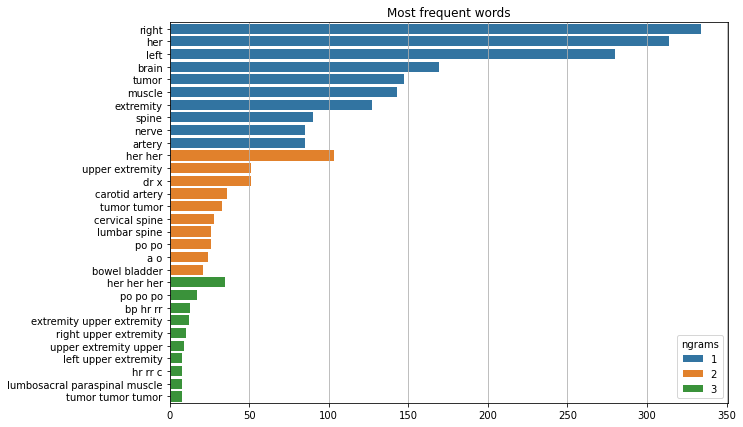

# Urology:


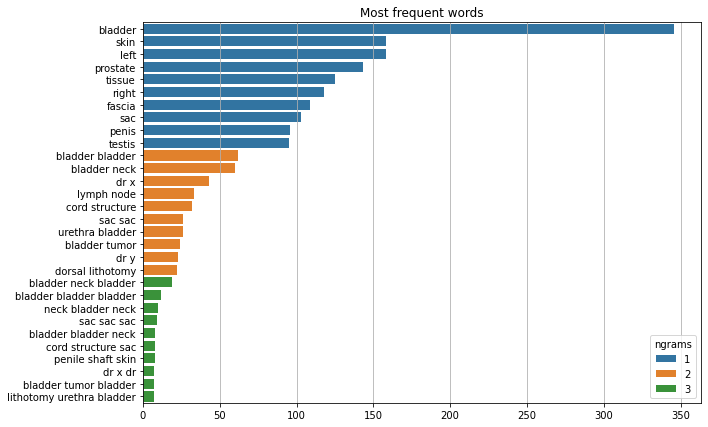

# Radiology:


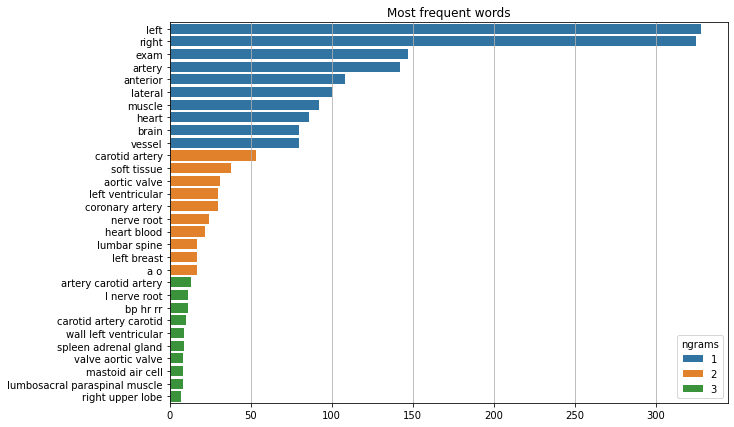

# Psychiatry / Psychology:


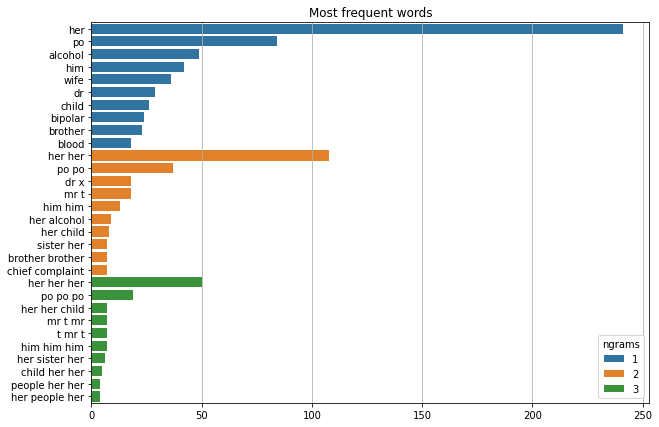

# Pediatrics - Neonatal:


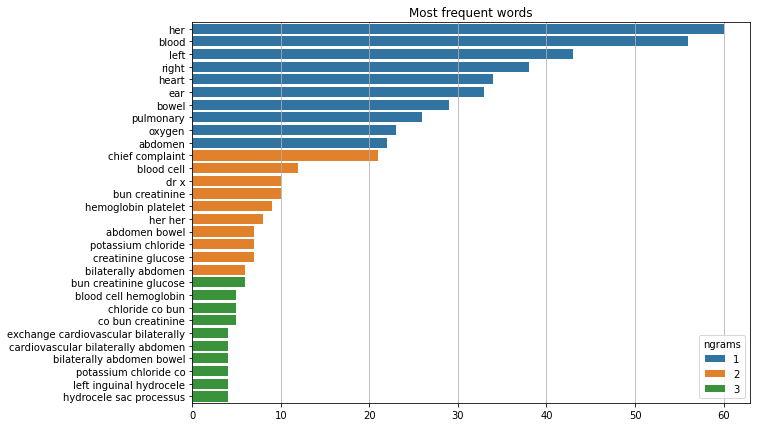

# Orthopedic:


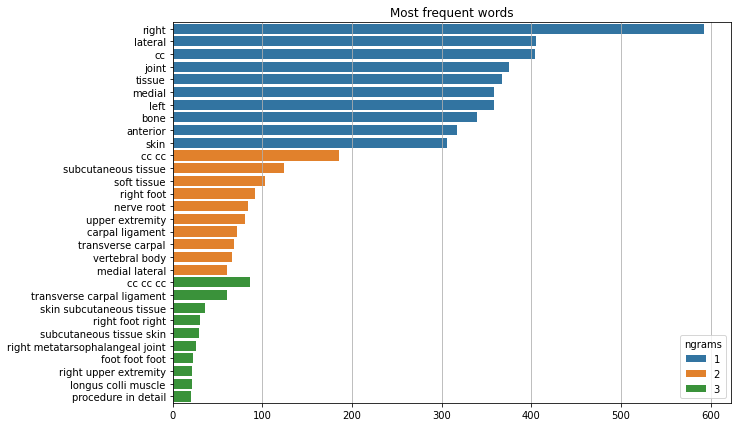

# Ophthalmology:


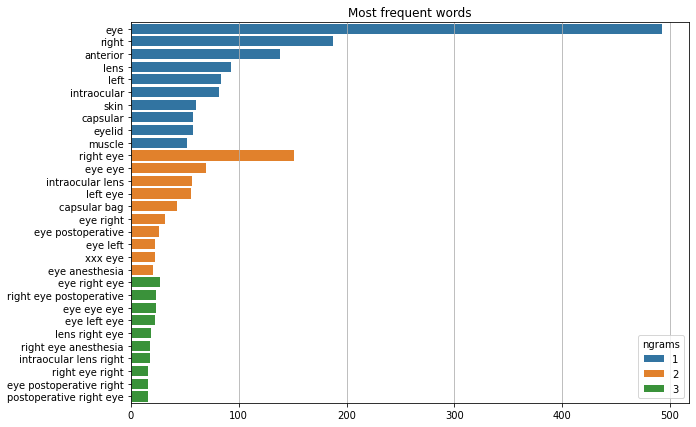

# Obstetrics / Gynecology:


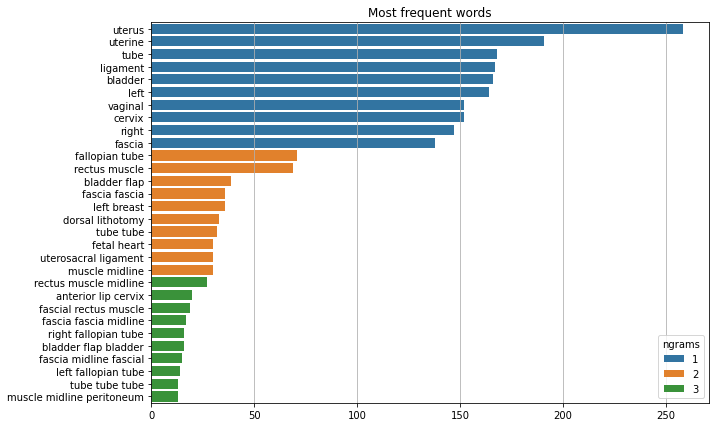

# Neurosurgery:


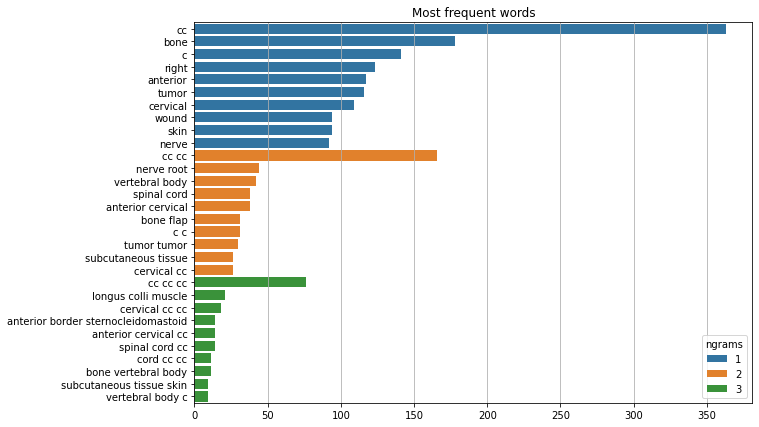

# Nephrology:


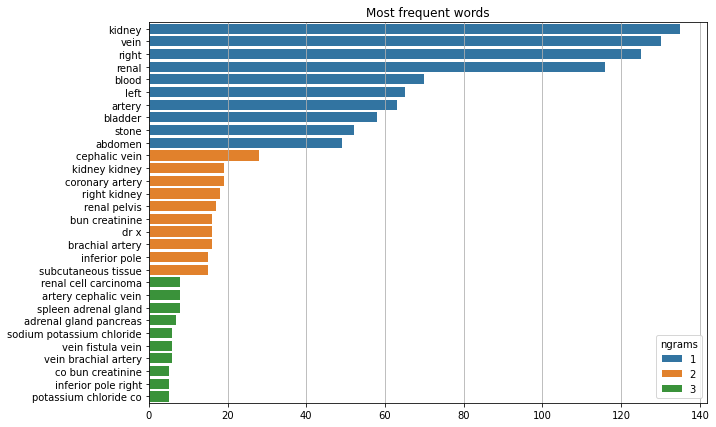

# Hematology - Oncology:


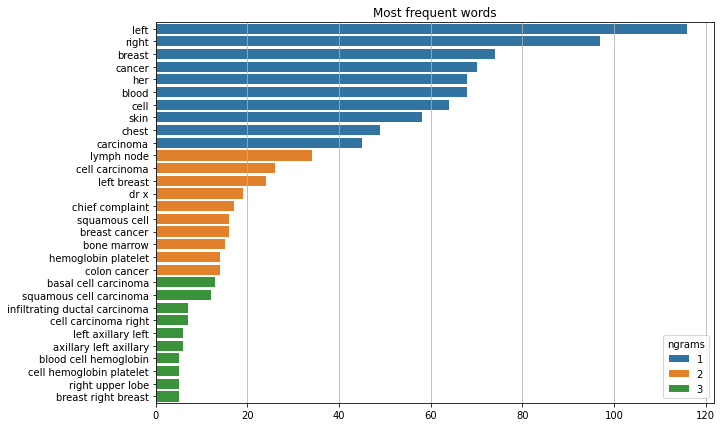

# Gastroenterology:


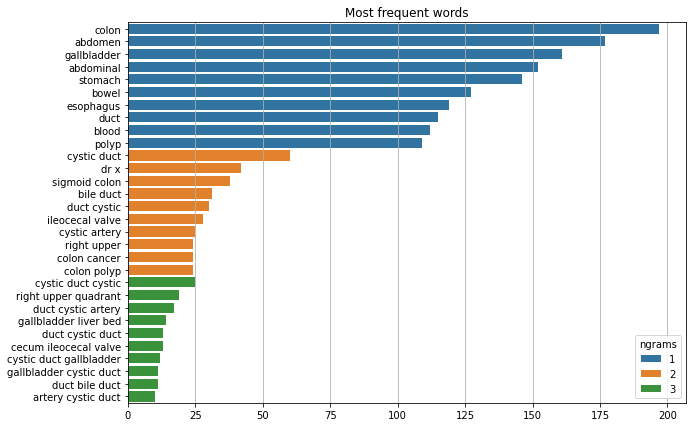

# ENT - Otolaryngology:


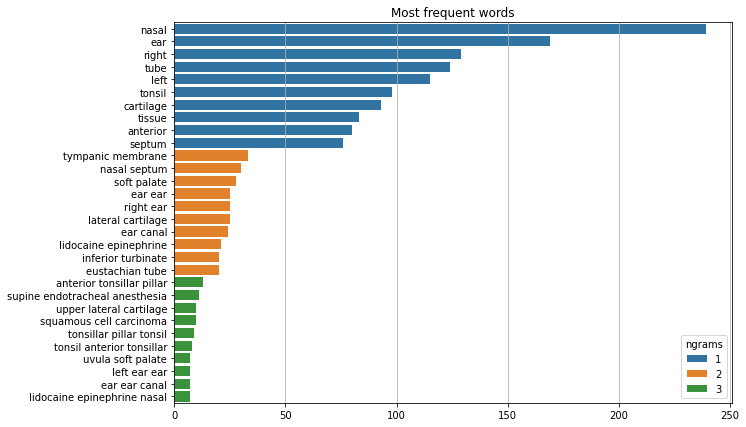

In [67]:
dtf_freq = pd.DataFrame()
for y in data2["y"].unique():
    print("# {}:".format(y))
    dtf_y = word_freq(corpus=data2[data2["y"]==y]["transcription_clean"], ngrams=[1,2,3], top=10, figsize=(10,7))
    dtf_y["y"] = y
    dtf_freq = dtf_freq.append(dtf_y)

In [68]:
data2['transcription']=data2['transcription_clean']
data2.drop(['transcription_clean'],axis=1,inplace=True)

In [69]:
# preprocess text
data2 = add_preprocessed_text(data2, "transcription", lst_regex=None, lst_stopwords=['her'], flg_stemm=False, flg_lemm=False)
data2.head()

--- found NAs ---
     transcription transcription_clean
2422       her her                    


,transcription,y,transcription_clean
3,left atrial left ventricle left ventricular pe...,Cardiovascular / Pulmonary,left atrial left ventricle left ventricular pe...
4,left ventricular wall wall left ventricular ve...,Cardiovascular / Pulmonary,left ventricular wall wall left ventricular ve...
7,heart vessel vessel pericardial venous right a...,Cardiovascular / Pulmonary,heart vessel vessel pericardial venous right a...
9,motion pericardial,Cardiovascular / Pulmonary,motion pericardial
11,study mitral left ventricular aortic stenosis ...,Cardiovascular / Pulmonary,study mitral left ventricular aortic stenosis ...


In [70]:
data2['transcription']=data2['transcription_clean']
data2.drop(['transcription_clean'],axis=1,inplace=True)

# Cardiovascular / Pulmonary:


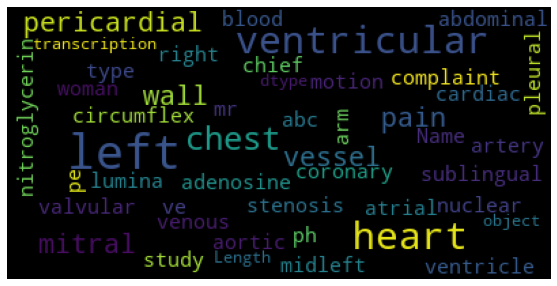

# Neurology:


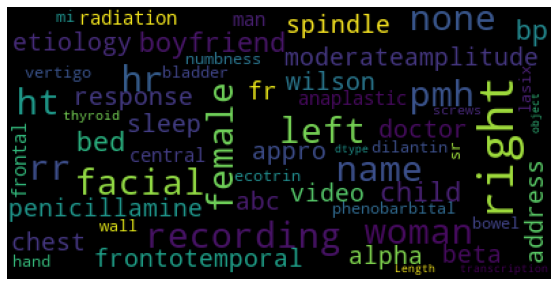

# Urology:


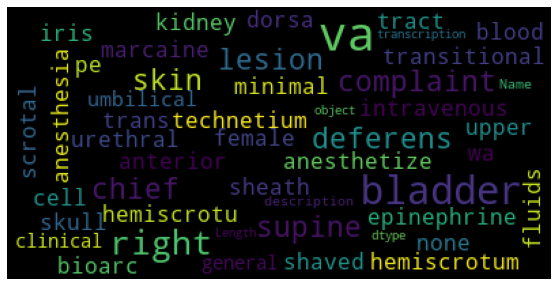

# Radiology:


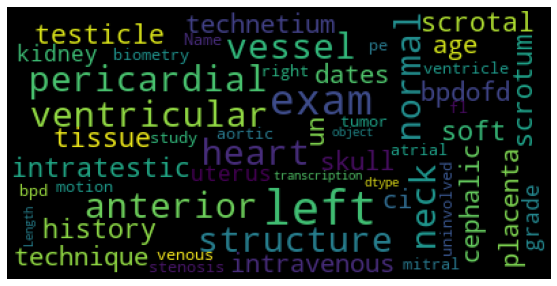

# Psychiatry / Psychology:


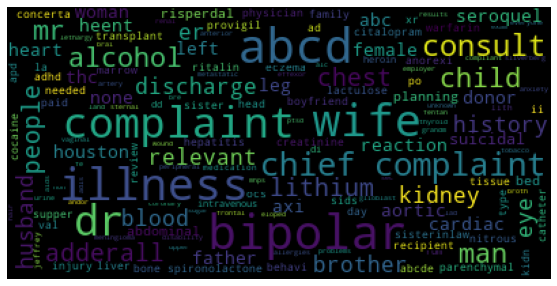

# Pediatrics - Neonatal:


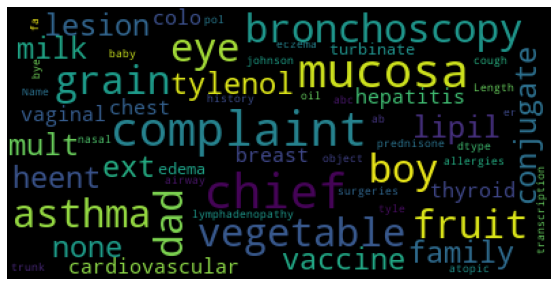

# Orthopedic:


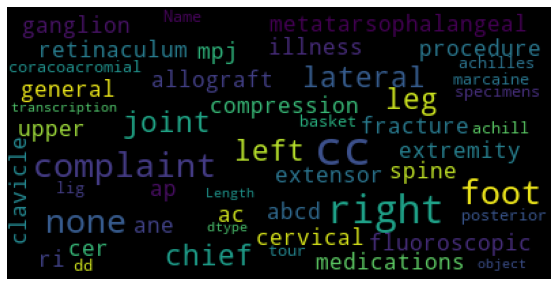

# Ophthalmology:


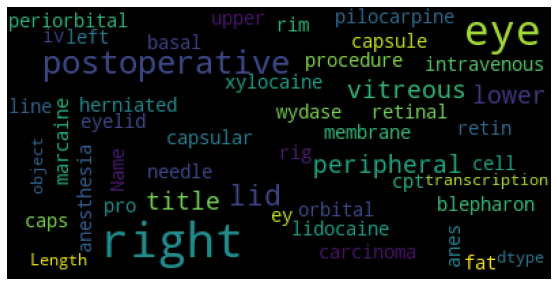

# Obstetrics / Gynecology:


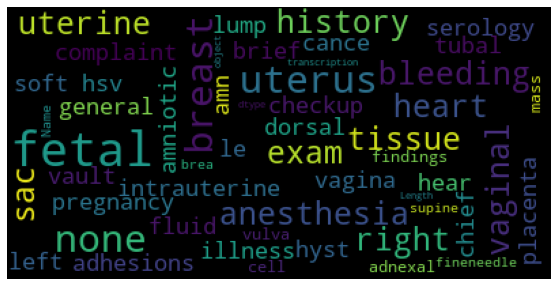

# Neurosurgery:


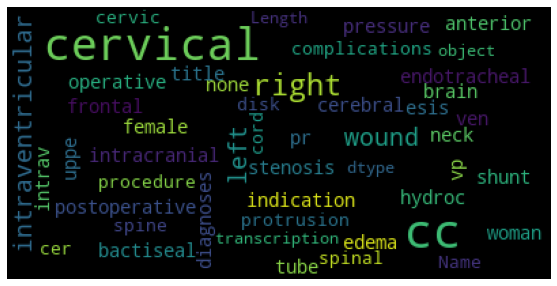

# Nephrology:


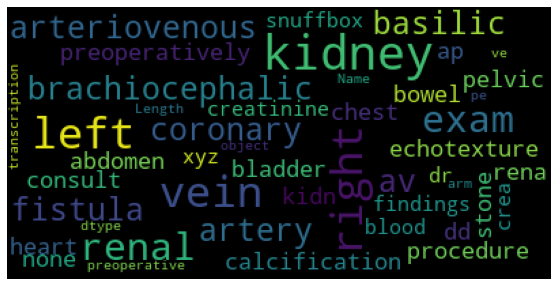

# Hematology - Oncology:


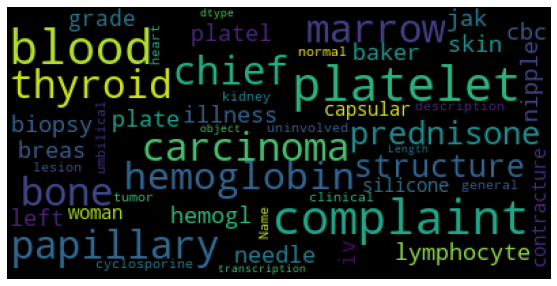

# Gastroenterology:


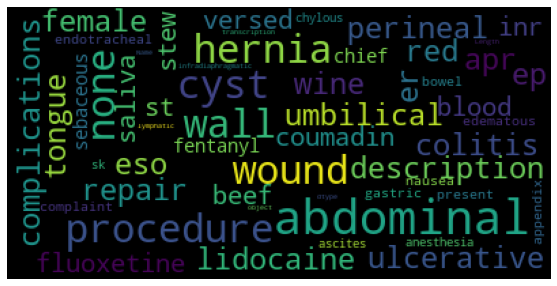

# ENT - Otolaryngology:


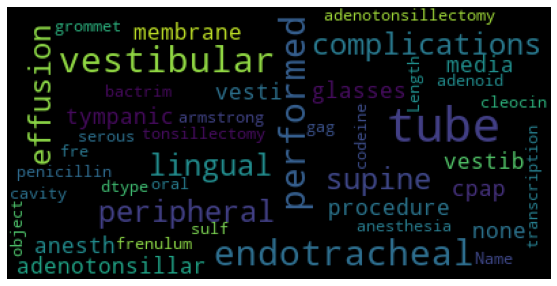

In [72]:
for y in data2["y"].unique():
    print("# {}:".format(y))
    plot_wordcloud(corpus=data2[data2["y"]==y]["transcription"], max_words=150, max_font_size=35, figsize=(10,5))

In [73]:
# not necessary
data2, dic_y_mapping = add_encode_variable(data, "y")

print(dic_y_mapping)
data2[["y","y_id"]].sample(5)

{0: 'Cardiovascular / Pulmonary', 1: 'ENT - Otolaryngology', 2: 'Gastroenterology', 3: 'Hematology - Oncology', 4: 'Nephrology', 5: 'Neurology', 6: 'Neurosurgery', 7: 'Obstetrics / Gynecology', 8: 'Ophthalmology', 9: 'Orthopedic', 10: 'Pediatrics - Neonatal', 11: 'Psychiatry / Psychology', 12: 'Radiology', 13: 'Urology'}


,y,y_id
67,Urology,13
3494,Gastroenterology,2
2878,Neurology,5
4634,Cardiovascular / Pulmonary,0
4936,Cardiovascular / Pulmonary,0


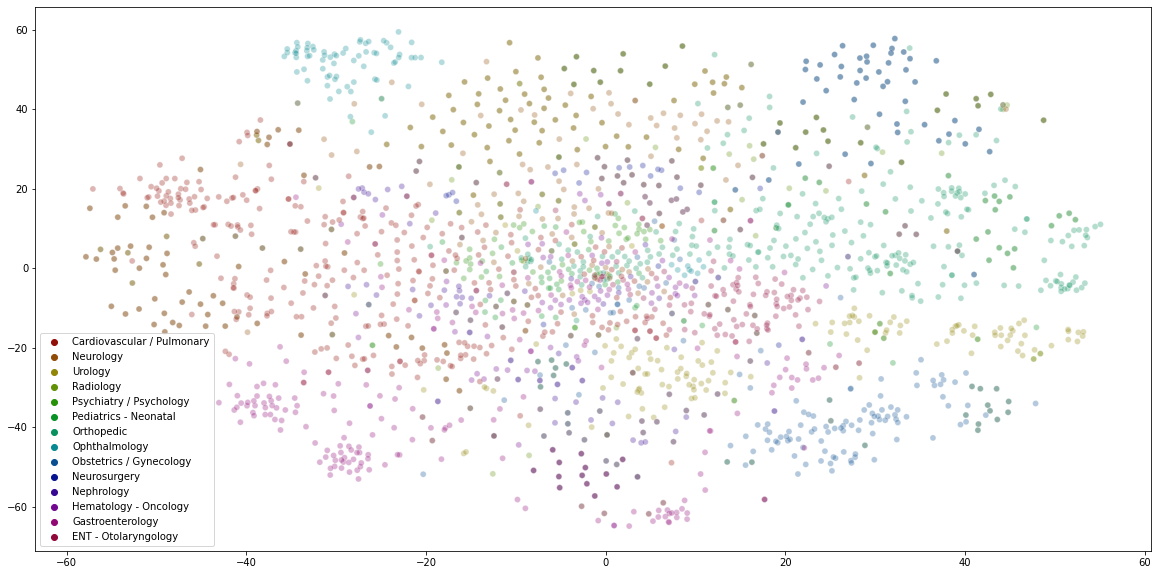

In [86]:
vectorizer = TfidfVectorizer(analyzer='word', stop_words='english',ngram_range=(1,3), max_df=0.75,min_df=5, use_idf=True, smooth_idf=True,sublinear_tf=True, max_features=1000)
tfIdfMat  = vectorizer.fit_transform(data2['transcription'].tolist() )

import gc
gc.collect()
tfIdfMatrix = tfIdfMat.todense()
labels = data2['y'].tolist()
tsne_results = TSNE(n_components=2,init='random',random_state=0, perplexity=40).fit_transform(tfIdfMatrix)
plt.figure(figsize=(20,10))
palette = sns.hls_palette(14, l=.3, s=.9)
sns.scatterplot(
    x=tsne_results[:,0], y=tsne_results[:,1],
    hue=labels,
    palette= palette,
    legend="full",
    alpha=0.3
)
plt.show()



In [87]:
pca = PCA(n_components=0.95)
tfIdfMat_reduced = pca.fit_transform(tfIdfMat.toarray())
labels = data2['y'].tolist()
category_list = data2.y.unique()

In [88]:
X_train, X_test, y_train, y_test = train_test_split(tfIdfMat_reduced, labels, stratify=labels,random_state=1)   
print('Train_Set_Size:'+str(X_train.shape))
print('Test_Set_Size:'+str(X_test.shape))

Train_Set_Size:(1743, 583)
Test_Set_Size:(581, 583)


In [89]:
clf = LogisticRegression(penalty= 'elasticnet', solver= 'saga', l1_ratio=0.5, random_state=1).fit(X_train, y_train)
y_test_pred= clf.predict(X_test)

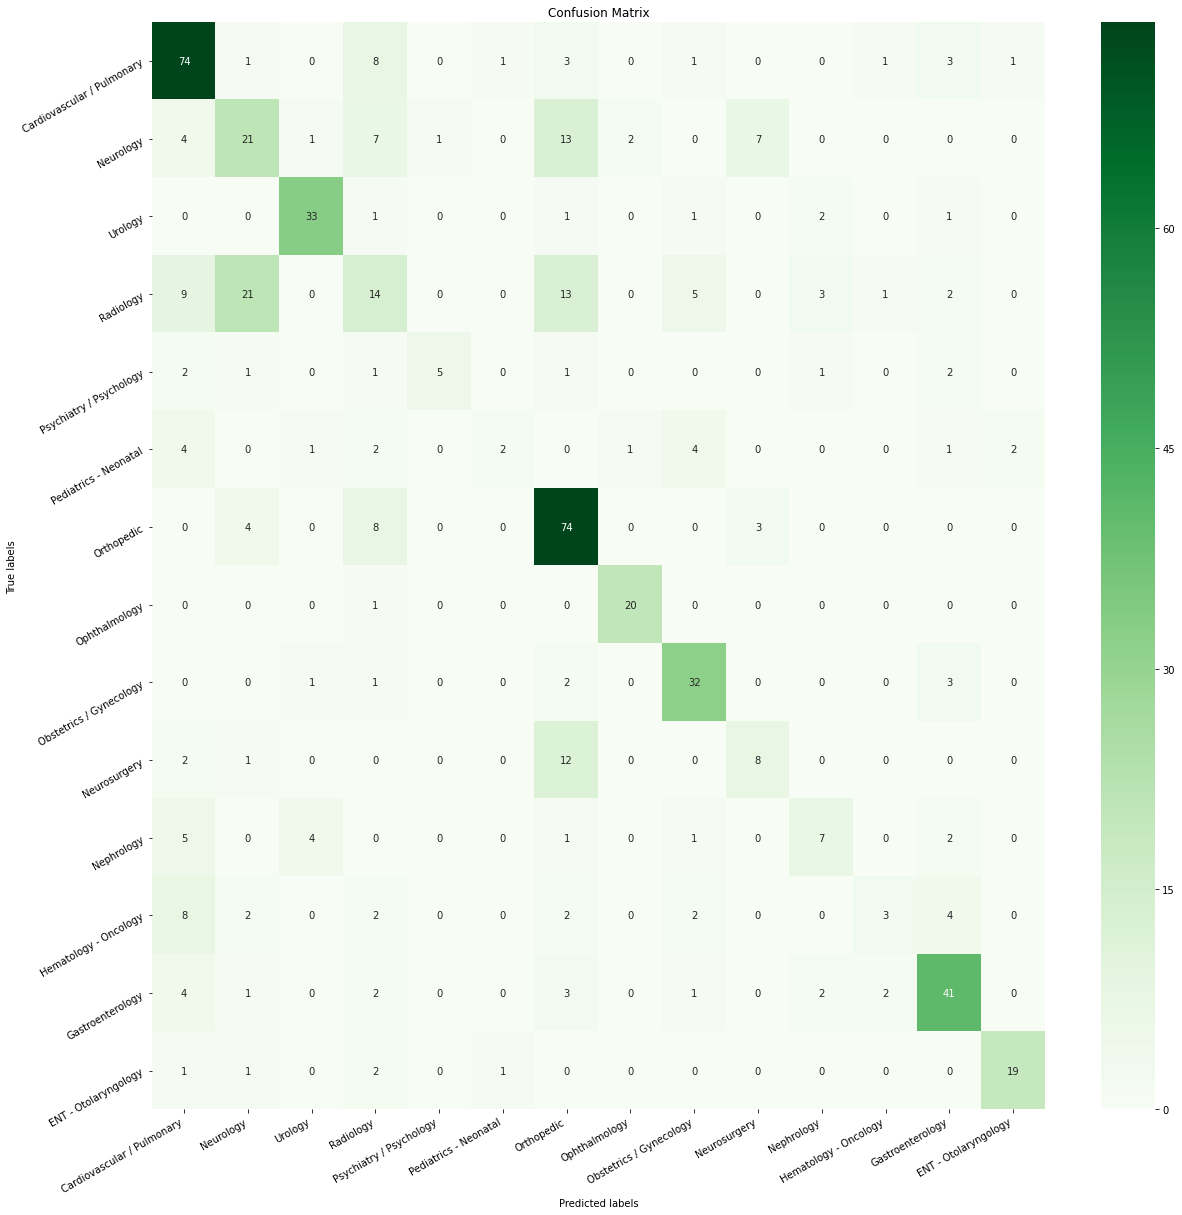

                            precision    recall  f1-score   support

Cardiovascular / Pulmonary       0.65      0.80      0.72        93
                 Neurology       0.40      0.38      0.39        56
                   Urology       0.82      0.85      0.84        39
                 Radiology       0.29      0.21      0.24        68
   Psychiatry / Psychology       0.83      0.38      0.53        13
     Pediatrics - Neonatal       0.50      0.12      0.19        17
                Orthopedic       0.59      0.83      0.69        89
             Ophthalmology       0.87      0.95      0.91        21
   Obstetrics / Gynecology       0.68      0.82      0.74        39
              Neurosurgery       0.44      0.35      0.39        23
                Nephrology       0.47      0.35      0.40        20
     Hematology - Oncology       0.43      0.13      0.20        23
          Gastroenterology       0.69      0.73      0.71        56
      ENT - Otolaryngology       0.86      0.79

In [90]:
labels = category_list
cm = confusion_matrix(y_test, y_test_pred, labels)

fig = plt.figure(figsize=(20,20))
ax= fig.add_subplot(1,1,1)
sns.heatmap(cm, annot=True, cmap="Greens",ax = ax,fmt='g'); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels);
plt.setp(ax.get_yticklabels(), rotation=30, horizontalalignment='right')
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')     
plt.show()
print(classification_report(y_test,y_test_pred,labels=category_list))


In [141]:
X_names, dtf_selection = features_selection(X_train, dtf_train["y"], X_names, top=None, print_top=10)

features selection: from 10,000 to 2,175
 
# Cardiovascular / Pulmonary:
  . selected features: 138
  . top features: coronary, artery, coronary artery, ventricular, pulmonary, heart, cardiac, chest, circumflex, right coronary
 
# ENT - Otolaryngology:
  . selected features: 238
  . top features: ear, nasal, tonsil, tympanic, tympanic membrane, adenoid, ear canal, tonsillar, right ear, turbinate
 
# Gastroenterology:
  . selected features: 231
  . top features: colon, stomach, polyp, cecum, gallbladder, esophagus, gastric, duct, duodenum, cystic duct
 
# Hematology - Oncology:
  . selected features: 118
  . top features: breast, platelet, cancer, patient platelet, chemotherapy, lymphoma, basal cell, pleural biopsy, iron, cell
 
# Nephrology:
  . selected features: 136
  . top features: kidney, renal, stone, basilic, basilic vein, ureter, creatinine, cephalic vein, right kidney, kidney kidney
 
# Neurology:
  . selected features: 96
  . top features: brain, cn, hct, cerebral, her, pmh, 